In [ ]:
!wget 'https://figshare.com/ndownloader/files/43283628' -O datasets.zip
!unzip datasets.zip

Streaming output truncated to the last 5000 lines.
 extracting: FracAtlas/Annotations/YOLO/IMG0003212.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003213.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003214.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003215.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003216.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003217.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003218.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003219.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003220.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003221.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003222.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003223.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003224.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003225.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003226.txt  
 extracting: FracAtlas/Annotations/YOLO/IMG0003227.txt  
 extracting: FracAtlas/Annotations/YO

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
frac_df = pd.read_csv('/content/FracAtlas/dataset.csv')
frac_df

,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
0,IMG0000000.jpg,0,1,0,0,0,0,1,0,0,1,1,0
1,IMG0000001.jpg,0,1,0,0,0,0,1,0,0,1,1,0
2,IMG0000002.jpg,0,1,0,0,0,0,1,0,0,1,1,0
3,IMG0000003.jpg,0,1,0,0,0,0,1,0,0,0,1,1
4,IMG0000004.jpg,0,1,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4078,IMG0004375.jpg,1,0,0,0,0,0,0,1,1,0,1,0
4079,IMG0004376.jpg,1,0,0,0,0,0,0,1,1,1,0,0
4080,IMG0004383.jpg,0,1,0,0,0,0,0,0,0,1,0,0
4081,IMG0004388.jpg,0,1,0,0,0,0,0,0,0,0,1,0


In [ ]:
frac_df.isnull().sum()

,0
image_id,0
hand,0
leg,0
hip,0
shoulder,0
mixed,0
hardware,0
multiscan,0
fractured,0
fracture_count,0


In [ ]:
frac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4083 entries, 0 to 4082
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_id        4083 non-null   object
 1   hand            4083 non-null   int64 
 2   leg             4083 non-null   int64 
 3   hip             4083 non-null   int64 
 4   shoulder        4083 non-null   int64 
 5   mixed           4083 non-null   int64 
 6   hardware        4083 non-null   int64 
 7   multiscan       4083 non-null   int64 
 8   fractured       4083 non-null   int64 
 9   fracture_count  4083 non-null   int64 
 10  frontal         4083 non-null   int64 
 11  lateral         4083 non-null   int64 
 12  oblique         4083 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 414.8+ KB


In [ ]:
frac_df.describe()

,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
count,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000
mean,0.376684,0.556699,0.082782,0.085476,0.097477,0.024247,0.096988,0.175606,0.225814,0.613030,0.365418,0.102376
std,0.484614,0.496836,0.275587,0.279624,0.296643,0.153834,0.295977,0.380531,0.544852,0.487116,0.481606,0.303179
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000


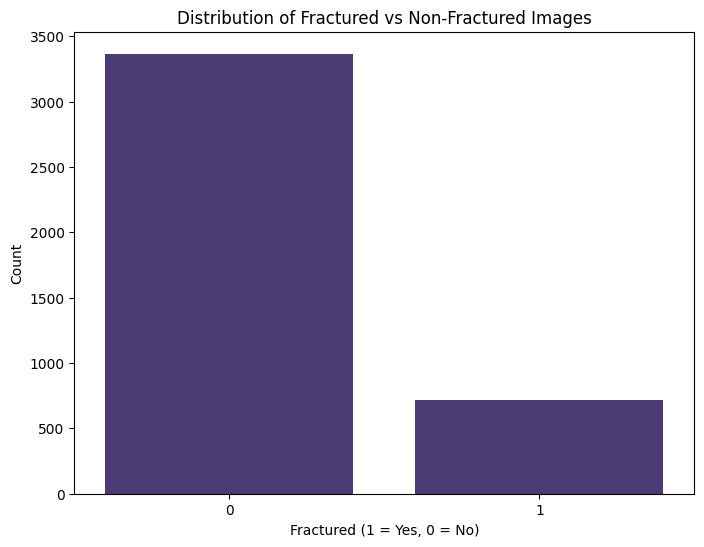

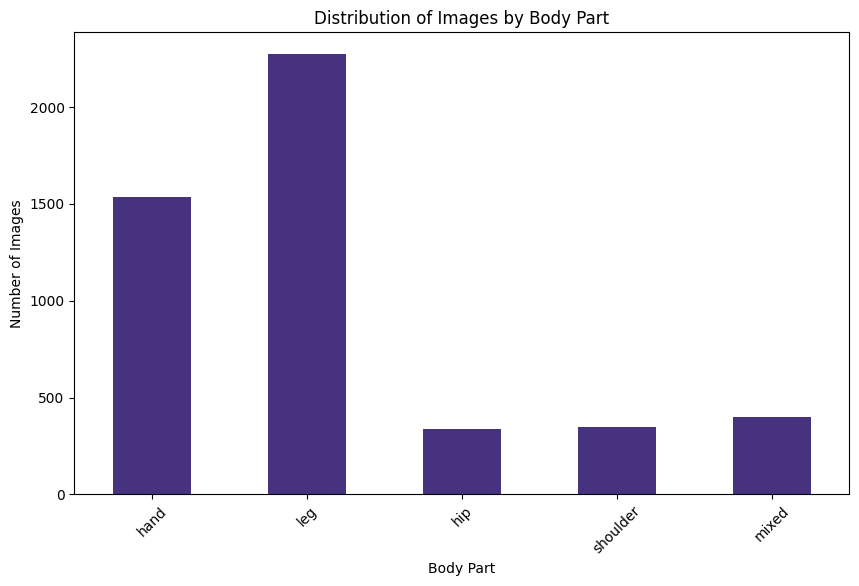

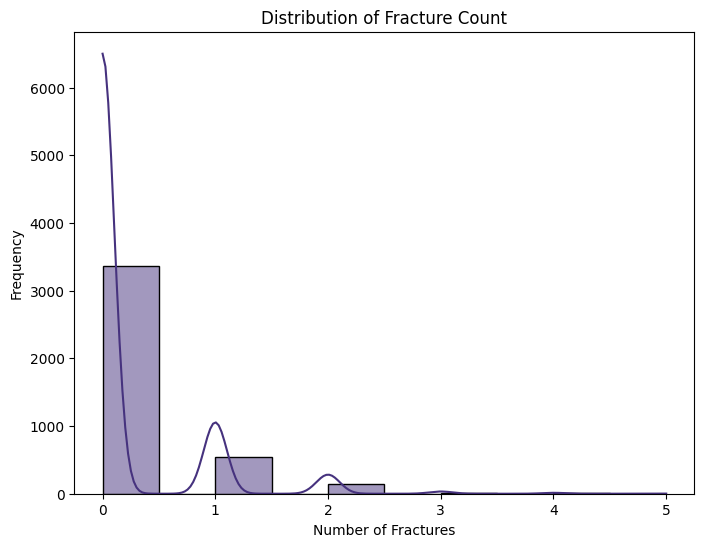

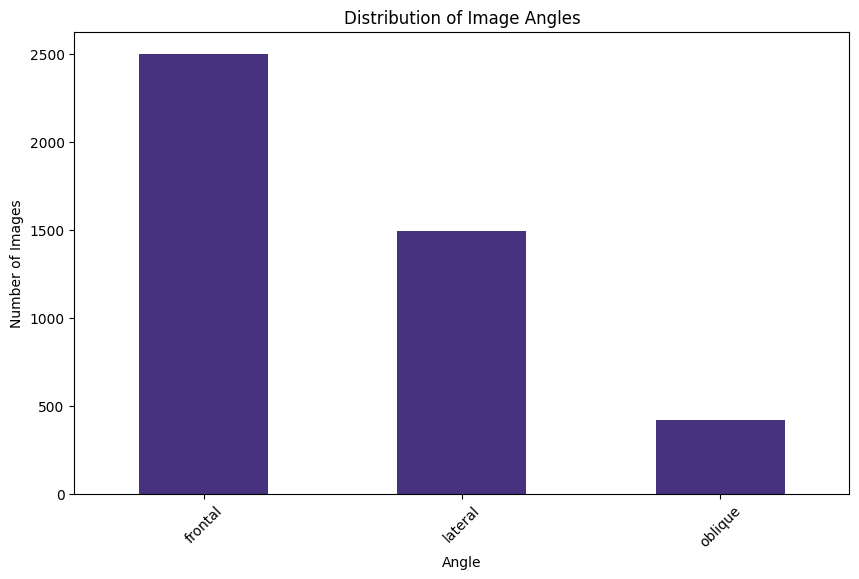

<Figure size 1200x800 with 0 Axes>

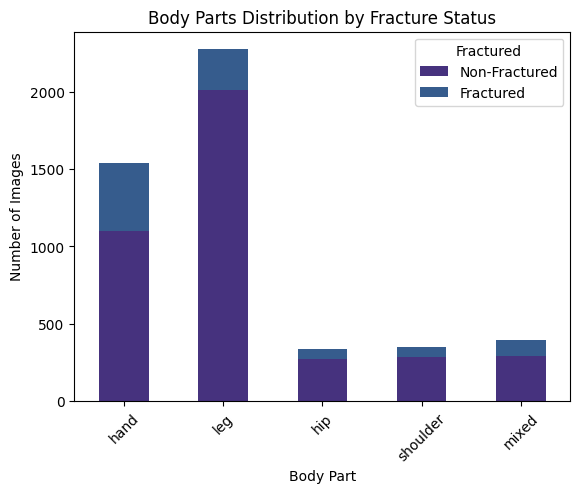

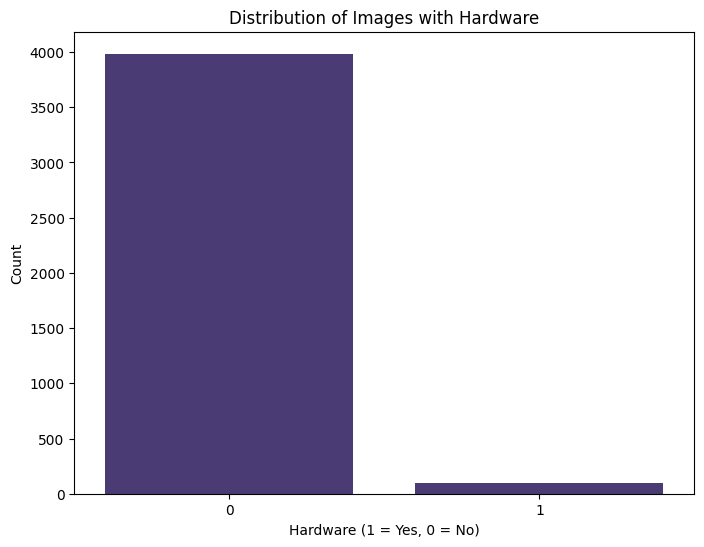

In [ ]:
# إعداد الإعدادات العامة للتصورات
# plt.style.use('whitegrid')  # استخدام نمط seaborn لتحسين المظهر
sns.set_palette('viridis')  # اختيار لوحة ألوان جذابة

# 1. توزيع الصور حسب وجود الكسر (Fractured vs Non-Fractured)
plt.figure(figsize=(8, 6))
sns.countplot(x='fractured', data=frac_df)
plt.title('Distribution of Fractured vs Non-Fractured Images')
plt.xlabel('Fractured (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

# 2. توزيع الصور حسب نوع العضو (Hand, Leg, Hip, Shoulder, Mixed)
body_parts = ['hand', 'leg', 'hip', 'shoulder', 'mixed']
body_counts = frac_df[body_parts].sum()
plt.figure(figsize=(10, 6))
body_counts.plot(kind='bar')
plt.title('Distribution of Images by Body Part')
plt.xlabel('Body Part')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# 3. توزيع عدد الكسور (Fracture Count)
plt.figure(figsize=(8, 6))
sns.histplot(frac_df['fracture_count'], bins=10, kde=True)
plt.title('Distribution of Fracture Count')
plt.xlabel('Number of Fractures')
plt.ylabel('Frequency')
plt.show()

# 4. توزيع الزوايا (Frontal, Lateral, Oblique)
angles = ['frontal', 'lateral', 'oblique']
angle_counts = frac_df[angles].sum()
plt.figure(figsize=(10, 6))
angle_counts.plot(kind='bar')
plt.title('Distribution of Image Angles')
plt.xlabel('Angle')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# 5. العلاقة بين وجود الكسر ونوع العضو
plt.figure(figsize=(12, 8))
body_fractured = frac_df[body_parts + ['fractured']].groupby('fractured').sum()
body_fractured.T.plot(kind='bar', stacked=True)
plt.title('Body Parts Distribution by Fracture Status')
plt.xlabel('Body Part')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend(title='Fractured', labels=['Non-Fractured', 'Fractured'])
plt.show()

# 6. توزيع الصور التي تحتوي على Hardware
plt.figure(figsize=(8, 6))
sns.countplot(x='hardware', data=frac_df)
plt.title('Distribution of Images with Hardware')
plt.xlabel('Hardware (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

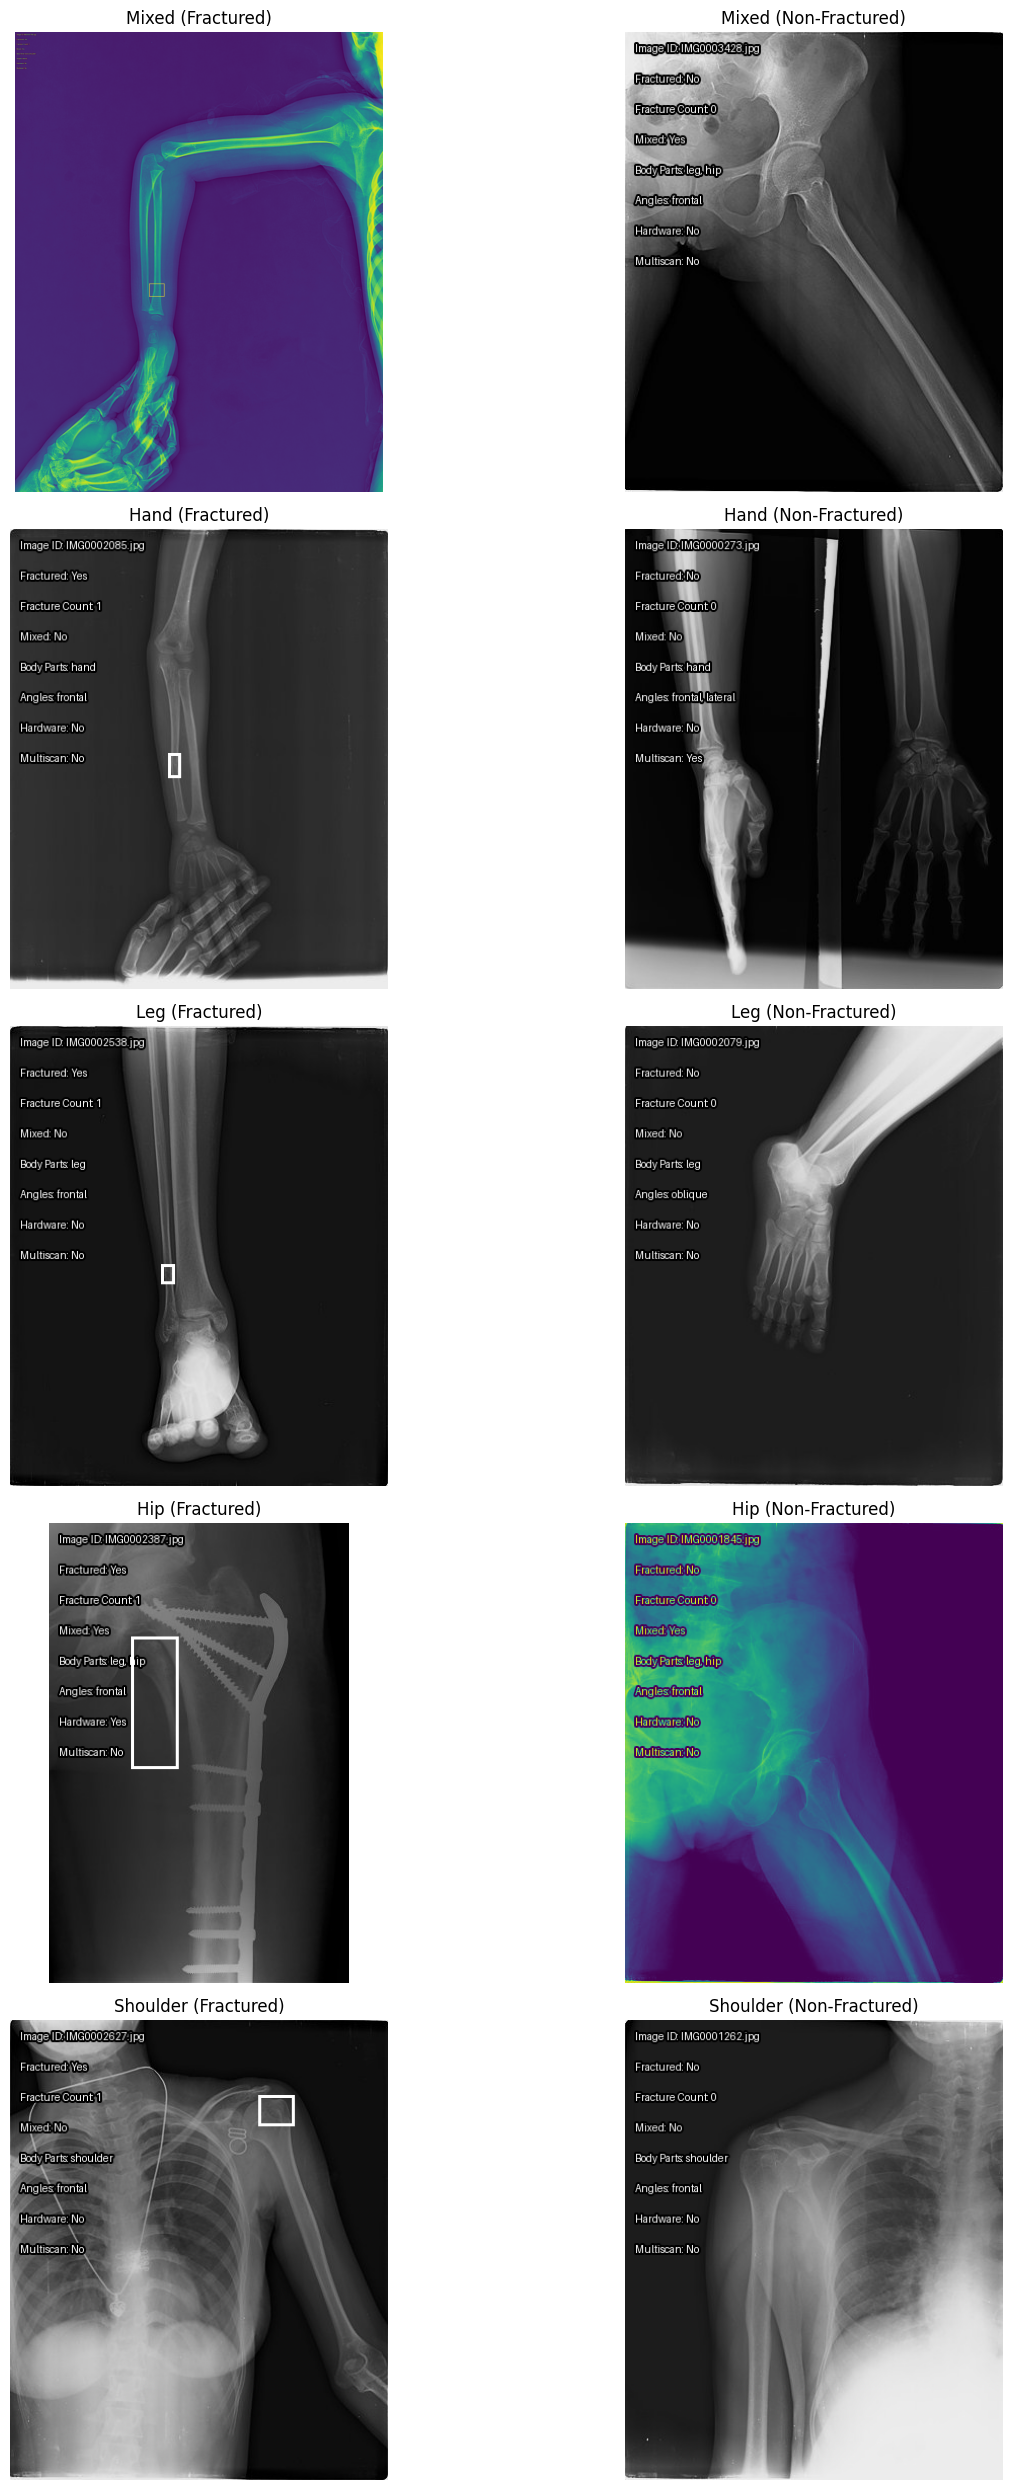

In [ ]:
fractured_dir = '/content/FracAtlas/images/Fractured'
non_fractured_dir = '/content/FracAtlas/images/Non_fractured'
yolo_annotations_dir = '/content/FracAtlas/Annotations/YOLO'

# دالة لاختيار صورة عشوائية بناءً على العضو أو حالة mixed وحالة الكسر
def get_random_image(directory, df, body_part, fractured_status):
    if body_part == 'mixed':
        # تصفية الصور التي mixed=True
        filtered_df = df[(df['mixed'] == 1) & (df['fractured'] == fractured_status)]
    else:
        # تصفية الصور بناءً على العضو
        filtered_df = df[(df[body_part] == 1) & (df['fractured'] == fractured_status)]
    image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.png'))]
    valid_images = [img for img in image_files if img in filtered_df['image_id'].values]
    if not valid_images:
        return None
    return random.choice(valid_images)

# دالة لاستخراج معلومات الصورة
def get_image_info(image_id, df):
    row = df[df['image_id'] == image_id].iloc[0]
    body_parts = ['hand', 'leg', 'hip', 'shoulder']
    angles = ['frontal', 'lateral', 'oblique']

    active_parts = [part for part in body_parts if row[part] == 1]
    active_parts = active_parts if active_parts else ['None']

    active_angles = [angle for angle in angles if row[angle] == 1]
    active_angles = active_angles if active_angles else ['None']

    info = (
        f"Image ID: {row['image_id']}\n"
        f"Fractured: {'Yes' if row['fractured'] == 1 else 'No'}\n"
        f"Fracture Count: {row['fracture_count']}\n"
        f"Mixed: {'Yes' if row['mixed'] == 1 else 'No'}\n"
        f"Body Parts: {', '.join(active_parts)}\n"
        f"Angles: {', '.join(active_angles)}\n"
        f"Hardware: {'Yes' if row['hardware'] == 1 else 'No'}\n"
        f"Multiscan: {'Yes' if row['multiscan'] == 1 else 'No'}"
    )
    return info

# دالة لتحميل Bounding Box من ملف YOLO
def get_bounding_boxes(image_id):
    annotation_file = os.path.join(yolo_annotations_dir, image_id.replace('.jpg', '.txt').replace('.png', '.txt'))
    bboxes = []
    if os.path.exists(annotation_file):
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    bboxes.append((class_id, x_center, y_center, width, height))
    return bboxes

# دالة لتحويل إحداثيات YOLO إلى إحداثيات Pillow
def yolo_to_pillow(bbox, img_width, img_height):
    _, x_center, y_center, width, height = bbox
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)
    return (x_min, y_min, x_max, y_max)

# دالة لكتابة المعلومات ورسم Bounding Box على الصورة
def draw_on_image(image, text, bboxes=None):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    lines = text.split('\n')
    x, y = 10, 10
    for line in lines:
        draw.text((x, y), line, fill='white', font=font, stroke_width=2, stroke_fill='black')
        y += 30

    if bboxes:
        img_width, img_height = image.size
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = yolo_to_pillow(bbox, img_width, img_height)
            draw.rectangle((x_min, y_min, x_max, y_max), outline='white', width=3)

    return image

# تحميل dataset.csv
frac_df = pd.read_csv('/content/FracAtlas/dataset.csv')

# الأعضاء مع وضع 'mixed' أولاً
body_parts = ['mixed', 'hand', 'leg', 'hip', 'shoulder']  # التعديل: mixed أولاً

# إعداد الشكل لعرض الصور
fig, axes = plt.subplots(len(body_parts), 2, figsize=(15, 5 * len(body_parts)))

# عرض صورة لكل فئة (Fractured وNon-Fractured)
for i, part in enumerate(body_parts):
    # اختيار صورة مكسورة
    fractured_image = get_random_image(fractured_dir, frac_df, part, 1)
    if fractured_image:
        fractured_img = Image.open(os.path.join(fractured_dir, fractured_image))
        fractured_info = get_image_info(fractured_image, frac_df)
        bboxes = get_bounding_boxes(fractured_image)
        fractured_img = draw_on_image(fractured_img, fractured_info, bboxes)
        axes[i, 0].imshow(fractured_img)
        axes[i, 0].set_title(f'{part.capitalize()} (Fractured)')
        axes[i, 0].axis('off')
    else:
        axes[i, 0].text(0.5, 0.5, f'No Fractured Image for {part.capitalize()}', ha='center', va='center')
        axes[i, 0].set_title(f'{part.capitalize()} (Fractured)')
        axes[i, 0].axis('off')

    # اختيار صورة غير مكسورة
    non_fractured_image = get_random_image(non_fractured_dir, frac_df, part, 0)
    if non_fractured_image:
        non_fractured_img = Image.open(os.path.join(non_fractured_dir, non_fractured_image))
        non_fractured_info = get_image_info(non_fractured_image, frac_df)
        non_fractured_img = draw_on_image(non_fractured_img, non_fractured_info)
        axes[i, 1].imshow(non_fractured_img)
        axes[i, 1].set_title(f'{part.capitalize()} (Non-Fractured)')
        axes[i, 1].axis('off')
    else:
        axes[i, 1].text(0.5, 0.5, f'No Non-Fractured Image for {part.capitalize()}', ha='center', va='center')
        axes[i, 1].set_title(f'{part.capitalize()} (Non-Fractured)')
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

# المسارات
vgg_json_path = "FracAtlas/Annotations/VGG JSON/VGG_fracture_masks.json"
images_dir = "/content/FracAtlas/images/Fractured"
output_images_dir = "/content/FracAtlas/fracture_dataset/images"
output_masks_dir = "/content/FracAtlas/fracture_dataset/masks"

# إنشاء المجلدات
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

# تحميل VGG JSON
with open(vgg_json_path) as f:
    vgg_data = json.load(f)

# تحويل كل صورة إلى mask
for filename, data in tqdm(vgg_data.items()):
    image_path = os.path.join(images_dir, filename)
    if not os.path.exists(image_path):
        continue

    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)

    for region_id, region_data in data["regions"].items():
        shape = region_data["shape_attributes"]
        all_x = shape["all_points_x"]
        all_y = shape["all_points_y"]
        polygon = list(zip(all_x, all_y))
        draw.polygon(polygon, outline=1, fill=1)

    image.save(os.path.join(output_images_dir, filename))
    mask_name = os.path.splitext(filename)[0] + ".png"
    mask.save(os.path.join(output_masks_dir, mask_name))


100%|██████████| 717/717 [00:15<00:00, 46.13it/s] 


In [ ]:
import albumentations as A

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),
    A.Resize(256, 256),
])

val_transform = A.Compose([
    A.Resize(256, 256)
])

def augment(image, mask, transform):
    def aug_fn(image, mask):
        data = {"image": image, "mask": mask}
        aug_data = transform(**data)
        return aug_data["image"], aug_data["mask"]

    image, mask = tf.numpy_function(func=aug_fn, inp=[image, mask], Tout=[tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])  # ← ضروري جدًا
    return image, mask

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import glob

image_files = sorted(glob.glob("/content/FracAtlas/fracture_dataset/images/*.jpg"))
mask_files  = sorted(glob.glob("/content/FracAtlas/fracture_dataset/masks/*.png"))

train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42)

def process(image_path, mask_path, img_size=256):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (img_size, img_size))
    mask = tf.cast(mask > 0, tf.float32)
    return image, mask

sample_image, sample_mask = process(train_images[0], train_masks[0])

print(f"Shape of a sample image: {sample_image.shape}")
print(f"Shape of a sample mask: {sample_mask.shape}")

Shape of a sample image: (256, 256, 3)
Shape of a sample mask: (256, 256, 1)


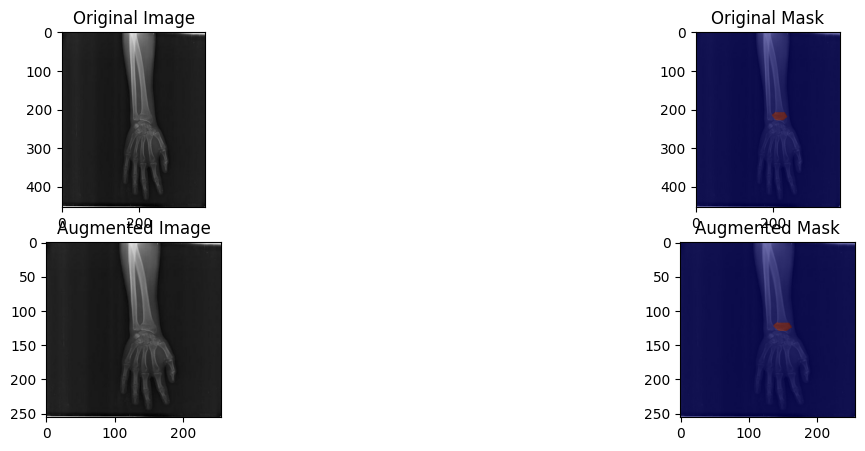

Unique values in augmented mask: [0 1]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def test_augmentation(image_path, mask_path, transform):
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))
    aug_data = transform(image=image, mask=mask)
    aug_image, aug_mask = aug_data['image'], aug_data['mask']

    plt.figure(figsize=(15, 5))
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.subplot(2, 2, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="jet", alpha=0.5)
    # plt.imshow(mask, cmap='gray')
    plt.title("Original Mask")
    plt.subplot(2, 2, 3)
    plt.imshow(aug_image)
    plt.title("Augmented Image")
    plt.subplot(2, 2, 4)
    plt.imshow(aug_image)
    plt.imshow(aug_mask, cmap="jet", alpha=0.5)
    # plt.imshow(aug_mask, cmap='gray')
    plt.title("Augmented Mask")
    plt.show()
    print(f"Unique values in augmented mask: {np.unique(aug_mask)}")
random_idx = np.random.randint(0, len(train_images))
test_augmentation(train_images[random_idx], train_masks[random_idx], train_transform)

In [ ]:
!pip install --upgrade segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from segmentation_models.losses import DiceLoss, BinaryFocalLoss
from segmentation_models.metrics import IOUScore, FScore
from tensorflow.keras.applications import ResNet50
from segmentation_models import Unet, FPN

BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess(image, mask):
    image = tf.cast(image, tf.float32)  # ← مهم جدًا
    image = preprocess_input(image)
    return image, mask

def create_dataset(image_paths, mask_paths, batch_size=4, augment_fn=None):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.shuffle(buffer_size=len(image_paths))

    def _load(x, y):
        image, mask = process(x, y)
        if augment_fn:
            image, mask = augment(image, mask, augment_fn)
        image, mask = preprocess(image, mask)
        return image, mask

    return dataset.map(_load, num_parallel_calls=tf.data.AUTOTUNE)\
                  .batch(batch_size)\
                  .prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(train_images, train_masks, batch_size=4, augment_fn=train_transform)
val_dataset   = create_dataset(val_images, val_masks, batch_size=4, augment_fn=val_transform)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


def focal_tversky_loss(y_true, y_pred):
    smooth = 1e-6
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)

    alpha = 0.7
    tversky = (tp + smooth) / (tp + alpha * fn + (1 - alpha) * fp + smooth)
    gamma = 0.75
    return tf.pow((1 - tversky), gamma)

model = FPN(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')

model.compile(
    optimizer=Adam(1e-4),
    loss=focal_tversky_loss,
    metrics=[IOUScore(threshold=0.5), FScore(threshold=0.5)]
)

Segmentation Models: using `tf.keras` framework.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
171164896/171164896 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, callbacks=callbacks)
model.save('my_model_v1.keras')
model.save_weights('my_model_weights_v1.weights.h5')

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 212s 601ms/step - f1-score: 0.0688 - iou_score: 0.0367 - loss: 0.9370 - val_f1-score: 8.4930e-09 - val_iou_score: 8.4930e-09 - val_loss: 0.9987 - learning_rate: 1.0000e-04
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 300ms/step - f1-score: 0.1774 - iou_score: 0.1014 - loss: 0.8321 - val_f1-score: 8.2988e-09 - val_iou_score: 8.2988e-09 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 297ms/step - f1-score: 0.2256 - iou_score: 0.1308 - loss: 0.7845 - val_f1-score: 8.3167e-09 - val_iou_score: 8.3167e-09 - val_loss: 0.9995 - learning_rate: 1.0000e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 80s 283ms/step - f1-score: 0.3144 - iou_score: 0.1950 - loss: 0.7091 - val_f1-score: 0.0073 - val_iou_score: 0.0039 - val_loss: 0.9936 - learning_rate: 5.0000e-05
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - f1-score: 0.3483 - iou_score: 0.2203 - loss: 0.6864 - val_f1-score: 0.0966 - val_iou_score: 0.0590 - 

In [ ]:
import numpy as np
from sklearn.metrics import jaccard_score

# تجهيز الليستات
y_true_list = []
y_pred_list = []

for batch in val_dataset:  # val_dataset هو tf.data.Dataset
    images, masks = batch
    preds = model.predict(images)

    # Apply threshold
    preds_bin = (preds > 0.5).astype(np.uint8)
    y_true_bin = masks.numpy().astype(np.uint8)

    # Flatten and extend
    y_true_list.extend(y_true_bin.flatten())
    y_pred_list.extend(preds_bin.flatten())

# تحويلهم لـ numpy arrays
y_true_array = np.array(y_true_list)
y_pred_array = np.array(y_pred_list)

# حساب الـ IoU لكل كلاس
iou_class_0 = jaccard_score((y_true_array == 0).astype(int), (y_pred_array == 0).astype(int))
iou_class_1 = jaccard_score((y_true_array == 1).astype(int), (y_pred_array == 1).astype(int))

iou = jaccard_score((y_true_array == 1).astype(int), (y_pred_array == 1).astype(int))
print(f"Final Fracture IoU: {iou:.4f}")
print(f"IoU - Background (class 0): {iou_class_0:.4f}")
print(f"IoU - Fracture (class 1): {iou_class_1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


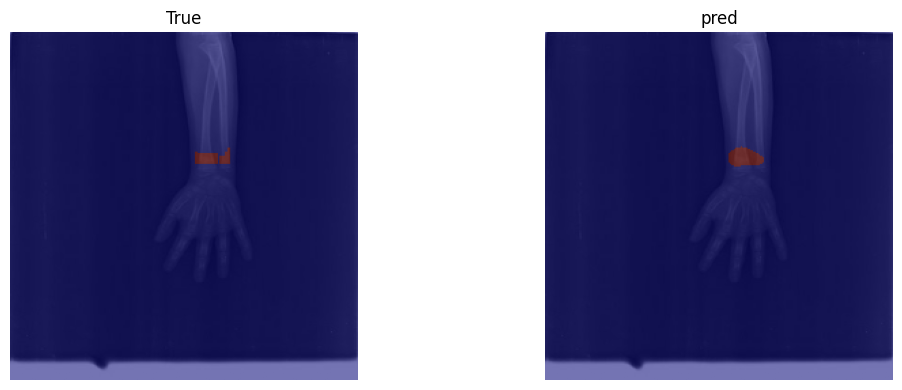

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

# ---------- اختيار صورة عشوائية ----------
print(len(image_files))
idx = random.randint(0, len(image_files) - 1)
image_path = image_files[idx]
mask_path = mask_files[idx]

# ---------- تحميل الصورة والماسك ----------
def load_and_preprocess(image_path, mask_path, img_size=256):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    image_preprocessed = preprocess_input(image)  # important

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (img_size, img_size))
    mask = tf.cast(mask > 0, tf.float32)

    return image, image_preprocessed, mask

image_raw, image_input, true_mask = load_and_preprocess(image_path, mask_path)

# ---------- توقع الموديل ----------
pred_mask = model.predict(tf.expand_dims(image_input, axis=0))[0]
pred_mask = tf.squeeze(pred_mask)  # إزالة البعد الزائد
pred_mask = tf.cast(pred_mask > 0.5, tf.float32)  # Threshold

# ---------- عرض النتائج ----------
plt.figure(figsize=(12, 4))

# عرض الصورة الأصلية
plt.subplot(1, 2, 1)
plt.title('True')
plt.imshow(image_raw)
plt.imshow(tf.squeeze(true_mask), cmap="jet", alpha=0.5)  # تراكب الماسك مع شفافية
plt.axis("off")

# عرض الصورة الأصلية مع توقعات الموديل
plt.subplot(1, 2, 2)
plt.title("pred")
plt.imshow(image_raw)
plt.imshow(pred_mask, cmap="jet", alpha=0.5)  # تراكب توقعات الموديل مع شفافية
plt.axis("off")

plt.tight_layout()
plt.show()